In [1]:
"""Example showing the optimization and evolution of surrogates"""

# Copyright (c) 2024 Alliance for Sustainable Energy, LLC

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

__authors__ = ["Weslley S. Pereira"]
__contact__ = "weslley.dasilvapereira@nrel.gov"
__maintainer__ = "Weslley S. Pereira"
__email__ = "weslley.dasilvapereira@nrel.gov"
__credits__ = ["Weslley S. Pereira"]
__version__ = "0.4.2"
__deprecated__ = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2d(x, y, FX, bounds, label):
    fig, ax = plt.subplots()
    im = ax.imshow(FX, cmap="jet", extent=[bounds[0][0],bounds[0][1],bounds[1][1],bounds[1][0]])
    fig.colorbar(im, ax=ax, label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.scatter(x[0:len(x)-1],y[0:len(x)-1],c='gray',marker='x')
    ax.scatter(x[-1],y[-1],c='w',marker='x')
    return fig, ax

In [3]:
def ackley(x, n: int = 2):
    from math import exp, sqrt, pi

    a = 20
    b = 0.2
    c = 2*pi
    return (
        -a * exp(-b * sqrt(np.dot(x, x) / n))
        - exp(np.sum(np.cos(c * np.asarray(x))) / n)
        + a
        + exp(1)
    )


def eggholder(x):
    return -(x[1]+47)*np.sin(np.sqrt(abs(x[1]+0.5*x[0]+47)))-x[0]*np.sin(np.sqrt(abs(x[0]-(x[1]+47))))

def quadratic(x):
    return (x[0] - 500)**2 + (x[1] - 2875)**2

objf = {}
# Breaks the symmetry of the problem
objf["ackley"] = lambda x: ackley([xi - 3.14 for xi in x], n=2)
objf["eggholder"] = eggholder
objf["quadratic"] = quadratic

refbounds = {}
refbounds["ackley"] = [-32.768, 32.768]
refbounds["eggholder"] = [-512, 512]
refbounds["quadratic"] = [0, 10000]

In [4]:
# Define dimensions and bounds
n = 2
funcstr = "eggholder"
bounds = [refbounds[funcstr]] * n

In [5]:
# Compute the mean and standard deviation of the GP
nx = 100
ny = 100
x = np.linspace(bounds[0][0], bounds[0][1], nx)
y = np.linspace(bounds[1][0], bounds[1][1], ny)
XY = np.array([[[x[j], y[i]] for j in range(nx)] for i in range(ny)])

In [6]:
import blackboxopt.optimize as bbopt
from blackboxopt.gp import GaussianProcess
from blackboxopt.acquisition import TargetValueAcquisition, expected_improvement
from blackboxopt.rbf import RbfModel, MedianLpfFilter
from sklearn.gaussian_process.kernels import RBF as GPkernelRBF
from scipy.linalg import ldl

savefig=False

def callback_rbf(out: bbopt.OptimizeResult):

    print("Best value of ", out.fx, " at ", out.x)
    print("Last sample point at ", out.sample[out.nfev-1])

    if (out.nfev % 10 == 0 and out.nfev >= 10) or savefig:
        model = RbfModel()
        model.reserve(0, n)
        model.update(out.sample[0:out.nfev,:], out.fsample[0:out.nfev])

        S = np.zeros((ny,nx))
        for i in range(ny):
            S[i, :], _ = model(XY[i, :])

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], S, bounds, "s(x,y)")
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

def callback_rbf_tv(out: bbopt.OptimizeResult):

    print("Best value of ", out.fx, " at ", out.x)
    print("Last sample point at ", out.sample[out.nfev-1])

    if (out.nfev % 10 == 0 and out.nfev >= 10) or savefig:
        model = RbfModel(filter=MedianLpfFilter())
        model.reserve(0, n)
        model.update(out.sample[0:out.nfev,:], out.fsample[0:out.nfev])

        S = np.zeros((ny,nx))
        MuMeas = np.zeros((ny,nx))
        LDLt = ldl(model.get_RBFmatrix())
        for i in range(ny):
            S[i, :], _ = model(XY[i, :])
            MuMeas[i, :] = TargetValueAcquisition.mu_measure(model, XY[i, :], LDLt)
        Gxmin = MuMeas * (S - 0)**2
        Gxmin[Gxmin > 1] = 1
        sqrtGxmin = np.sqrt(MuMeas) * np.absolute(S - 0)
        sqrtGxmin[sqrtGxmin > 1] = 1

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], S, bounds, "s(x,y)")
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], np.log(MuMeas), bounds, "log(muMeas(x,y))")
        if savefig:
            plt.savefig("logMuMeas_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], Gxmin, bounds, r"$g_{xmin}(x,y)$")
        if savefig:
            plt.savefig("gxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], np.log(Gxmin), bounds, r"$log(g_{xmin}(x,y))$")
        if savefig:
            plt.savefig("logGxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], sqrtGxmin, bounds, r"$\sqrt{g_{xmin}(x,y)}$")
        if savefig:
            plt.savefig("sqrtGxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], -1/Gxmin, bounds, r"$-1/g_{xmin}(x,y)$")
        if savefig:
            plt.savefig("minusOneOverGxmin_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

def callback_gp(out: bbopt.OptimizeResult):

    print("Best value of ", out.fx, " at ", out.x)
    print("Last sample point at ", out.sample[out.nfev-1])

    if (out.nfev % 10 == 0 and out.nfev >= 10) or savefig:
        model = GaussianProcess(GPkernelRBF(), n_restarts_optimizer=20, normalize_y=True)
        model.update(out.sample[0:out.nfev,:], out.fsample[0:out.nfev])

        Mean = np.zeros((ny,nx))
        Std = np.zeros((ny,nx))
        EI = np.zeros((ny,nx))
        for i in range(ny):
            Mean[i, :], Std[i, :] = model(XY[i, :])
            EI[i, :] = expected_improvement(Mean[i, :], Std[i, :], out.fx)

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], Mean, bounds, "s(x,y)")
        if savefig:
            plt.savefig("surrogate_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

        plot_2d(out.sample[0:out.nfev,0], out.sample[0:out.nfev,1], EI, bounds, "EI(x,y)")
        if savefig:
            plt.savefig("EI_{:03d}.png".format(out.nfev))
        if out.nfev % 10 == 0:
            plt.show()
        else:
            plt.close()

Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [ 426.66666667 -256.        ]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-496.74471479 -130.02226723]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [ 132.58869373 -506.66618522]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-500.92556474 -506.35224934]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-221.14558499 -409.5515213 ]


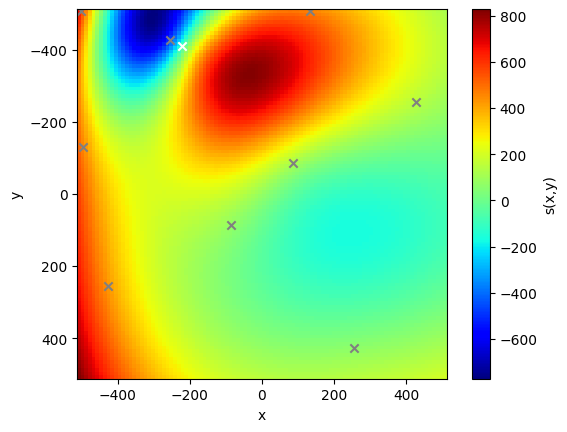

Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-206.36618558 -147.72280214]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-353.45431566 -508.58966415]
Best value of  -449.3048641148615  at  [-256.         -426.66666667]
Last sample point at  [-393.24945762 -348.45128659]
Best value of  -598.2630529471995  at  [-292.78108566 -444.53558849]
Last sample point at  [-292.78108566 -444.53558849]
Best value of  -598.2630529471995  at  [-292.78108566 -444.53558849]
Last sample point at  [ -83.58271514 -507.54294488]
Best value of  -598.2630529471995  at  [-292.78108566 -444.53558849]
Last sample point at  [-395.0803947   -30.01946964]
Best value of  -598.2630529471995  at  [-292.78108566 -444.53558849]
Last sample point at  [-261.39488952 -497.59534399]
Best value of  -598.2630529471995  at  [-292.78108566 -444.53558849]
Last sample point at  [-292.78108566 -423.11842616]
Best value of  -598.263052947199

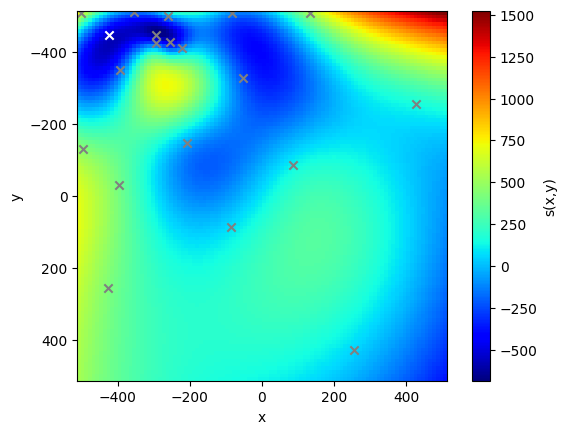

Best value of  -598.2630529471995  at  [-292.78108566 -444.53558849]
Last sample point at  [-453.6201463 -410.527845 ]
Best value of  -676.795461020356  at  [-282.61753489 -458.13459668]
Last sample point at  [-282.61753489 -458.13459668]
Best value of  -676.795461020356  at  [-282.61753489 -458.13459668]
Last sample point at  [-123.5330834  -388.98689026]
Best value of  -676.795461020356  at  [-282.61753489 -458.13459668]
Last sample point at  [-363.71430942 -446.81632564]
Best value of  -693.2137496608497  at  [-296.6458052  -458.13459668]
Last sample point at  [-296.6458052  -458.13459668]
Best value of  -702.3970962539797  at  [-296.6458052  -461.22160836]
Last sample point at  [-296.6458052  -461.22160836]
Best value of  -702.3970962539797  at  [-296.6458052  -461.22160836]
Last sample point at  [-169.48365943 -483.2688886 ]
Best value of  -702.3970962539797  at  [-296.6458052  -461.22160836]
Last sample point at  [-217.81699064 -461.22160836]
Best value of  -702.3970962539797  at

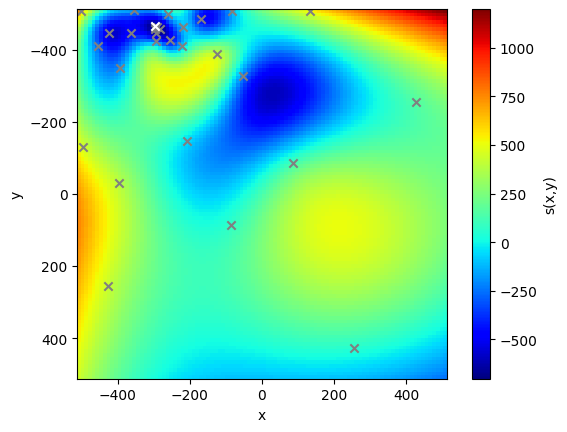

Best value of  -703.8729074710284  at  [-296.6458052  -464.18692973]
Last sample point at  [-296.6458052  -310.91859845]
Best value of  -703.8729074710284  at  [-296.6458052  -464.18692973]
Last sample point at  [-332.34791362 -464.18692973]
Best value of  -703.8729074710284  at  [-296.6458052  -464.18692973]
Last sample point at  [-292.50287083 -464.18692973]
Best value of  -704.1769739490837  at  [-296.6458052  -463.23454752]
Last sample point at  [-296.6458052  -463.23454752]
Best value of  -704.1769739490837  at  [-296.6458052  -463.23454752]
Last sample point at  [-208.54704325 -282.02043366]
Best value of  -704.1769739490837  at  [-296.6458052  -463.23454752]
Last sample point at  [-314.58322057 -498.67212916]
Best value of  -704.1769739490837  at  [-296.6458052  -463.23454752]
Last sample point at  [-294.51677056 -463.23454752]
Best value of  -704.5124714725748  at  [-295.47583469 -463.23454752]
Last sample point at  [-295.47583469 -463.23454752]
Best value of  -704.512471472574

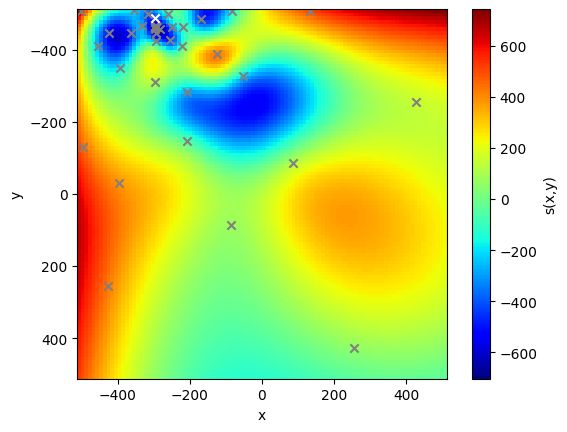

Best value of  -704.5124714725748  at  [-295.47583469 -463.23454752]
Last sample point at  [-289.14848754 -454.31840346]
Best value of  -704.5249924330647  at  [-295.47583469 -461.88437849]
Last sample point at  [-295.47583469 -461.88437849]
Best value of  -704.5249924330647  at  [-295.47583469 -461.88437849]
Last sample point at  [-268.3404492  -471.44074203]
Best value of  -704.5249924330647  at  [-295.47583469 -461.88437849]
Last sample point at  [-310.26532007 -471.9814641 ]
Best value of  -704.5249924330647  at  [-295.47583469 -461.88437849]
Last sample point at  [-302.00987883 -471.1690674 ]
Best value of  -704.7013151148897  at  [-294.00549377 -461.88437849]
Last sample point at  [-294.00549377 -461.88437849]
Best value of  -704.7013151148897  at  [-294.00549377 -461.88437849]
Last sample point at  [-307.20146572 -461.88437849]
Best value of  -704.7013151148897  at  [-294.00549377 -461.88437849]
Last sample point at  [-294.00549377 -472.23268008]
Best value of  -704.701315114889

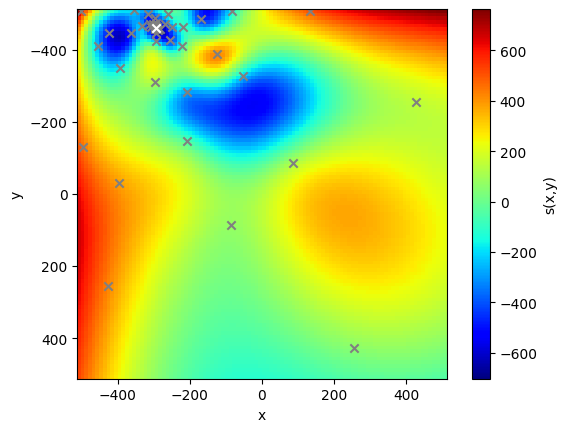

Best value of  -704.7013151148897  at  [-294.00549377 -461.88437849]
Last sample point at  [-300.94373471 -466.14268528]
Best value of  -704.7013151148897  at  [-294.00549377 -461.88437849]
Last sample point at  [-296.63282016 -467.87050765]
Best value of  -704.7013151148897  at  [-294.00549377 -461.88437849]
Last sample point at  [-290.98841055 -459.08597104]
Best value of  -704.7929349931483  at  [-294.73610312 -461.88437849]
Last sample point at  [-294.73610312 -461.88437849]
Best value of  -704.7929349931483  at  [-294.73610312 -461.88437849]
Last sample point at  [-294.73610312 -452.53773906]

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

Best value of  -704.7929349931483  at  [-294.73610312 -461.88437849]
Last sample point at  [nan nan]
Best value of  -704.7929349931483  at  [-294.73610312 -461.88437849]
Last sample point 

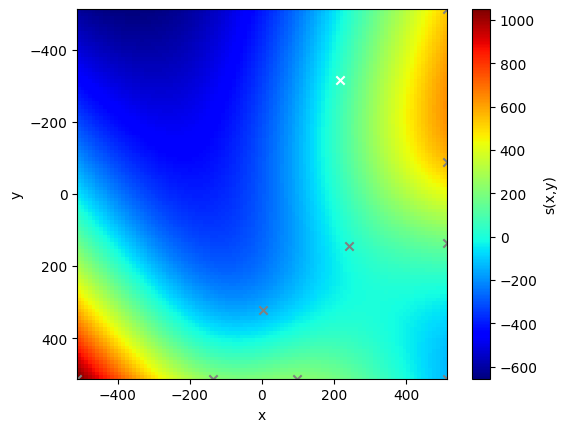

Best value of  -762.3311519377678  at  [-340.67215421  511.99999943]
Last sample point at  [-340.67215421  511.99999943]
Best value of  -762.3311519377678  at  [-340.67215421  511.99999943]
Last sample point at  [-339.39903034  488.78167888]
Best value of  -762.3311519377678  at  [-340.67215421  511.99999943]
Last sample point at  [-511.91209498   99.79732414]
Best value of  -762.3311519377678  at  [-340.67215421  511.99999943]
Last sample point at  [ 336.65347535 -512.        ]
Best value of  -762.3311519377678  at  [-340.67215421  511.99999943]
Last sample point at  [325.66838491 -58.7505671 ]
Best value of  -762.3311519377678  at  [-340.67215421  511.99999943]
Last sample point at  [511.99999983 332.85563822]
Best value of  -762.3311519377678  at  [-340.67215421  511.99999943]
Last sample point at  [-286.93249952  147.31764454]
Best value of  -762.3311519377678  at  [-340.67215421  511.99999943]
Last sample point at  [ 75.96486886 165.13933138]
Best value of  -762.3311519377678  at 

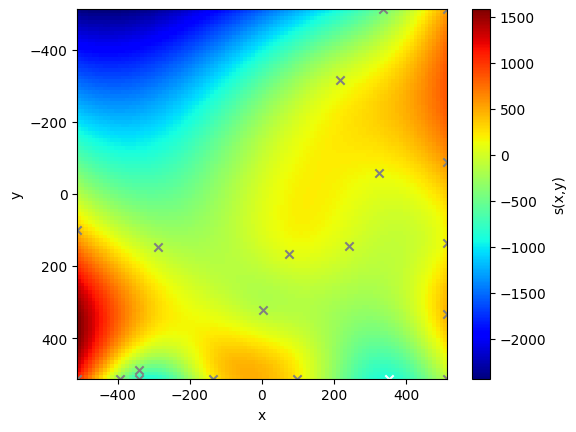

Best value of  -855.8033114204723  at  [352.85475922 511.99999999]
Last sample point at  [-283.75162509  512.        ]
Best value of  -855.8033114204723  at  [352.85475922 511.99999999]
Last sample point at  [376.28426951 512.        ]
Best value of  -855.8033114204723  at  [352.85475922 511.99999999]
Last sample point at  [319.66652914 511.99999999]
Best value of  -856.9723546848918  at  [353.68879598 512.        ]
Last sample point at  [353.68879598 512.        ]
Best value of  -856.9723546848918  at  [353.68879598 512.        ]
Last sample point at  [-192.26596645  310.73288824]
Best value of  -856.9723546848918  at  [353.68879598 512.        ]
Last sample point at  [367.60765375 278.95163757]
Best value of  -856.9723546848918  at  [353.68879598 512.        ]
Last sample point at  [ 511.99999985 -363.38224336]
Best value of  -856.9723546848918  at  [353.68879598 512.        ]
Last sample point at  [ 365.60630134 -397.14999806]
Best value of  -856.9723546848918  at  [353.68879598 512

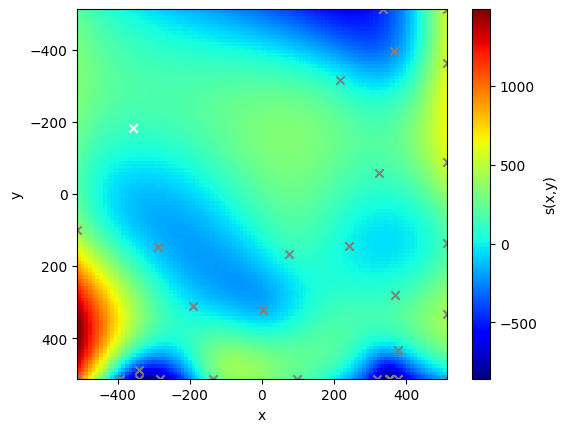

Best value of  -856.9723546848918  at  [353.68879598 512.        ]
Last sample point at  [ -47.97596924 -144.9178358 ]
Best value of  -856.9723546848918  at  [353.68879598 512.        ]
Last sample point at  [170.20497032 292.99225813]
Best value of  -856.9723546848918  at  [353.68879598 512.        ]
Last sample point at  [ 218.76638682 -169.60105515]
Best value of  -856.9723546848918  at  [353.68879598 512.        ]
Last sample point at  [392.49392221  82.07294179]
Best value of  -856.9723546848918  at  [353.68879598 512.        ]
Last sample point at  [  80.83503856 -252.33232343]
Best value of  -858.3116783971223  at  [355.22993505 512.        ]
Last sample point at  [355.22993505 512.        ]
Best value of  -858.3116783971223  at  [355.22993505 512.        ]
Last sample point at  [-511.99831025  354.21721351]
Best value of  -858.3116783971223  at  [355.22993505 512.        ]
Last sample point at  [-220.77686154    4.88212587]
Best value of  -858.3116783971223  at  [355.22993505 5

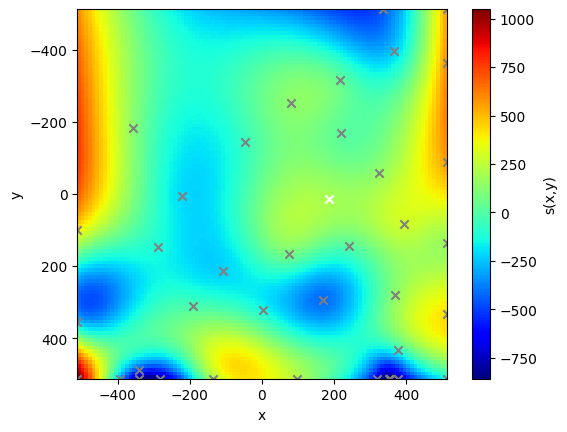

Best value of  -858.3116783971223  at  [355.22993505 512.        ]
Last sample point at  [  75.21320146 -397.70467333]
Best value of  -858.3116783971223  at  [355.22993505 512.        ]
Last sample point at  [-512.          228.38175852]
Best value of  -858.3116783971223  at  [355.22993505 512.        ]
Last sample point at  [ 238.9208058 -456.11617  ]
Best value of  -858.3116783971223  at  [355.22993505 512.        ]
Last sample point at  [ 511.99999999 -215.66217861]
Best value of  -858.3116783971223  at  [355.22993505 512.        ]
Last sample point at  [17.03971168 15.00383539]


OptimizeResult(x=array([355.22993505, 512.        ]), fx=-858.3116783971223, nit=2, nfev=100, sample=array([[-426.66666667,  256.        ],
       [-256.        , -426.66666667],
       [ -85.33333333,   85.33333333],
       [  85.33333333,  -85.33333333],
       [ 256.        ,  426.66666667],
       [ 426.66666667, -256.        ],
       [-496.74471479, -130.02226723],
       [ 132.58869373, -506.66618522],
       [-500.92556474, -506.35224934],
       [-221.14558499, -409.5515213 ],
       [-206.36618558, -147.72280214],
       [-353.45431566, -508.58966415],
       [-393.24945762, -348.45128659],
       [-292.78108566, -444.53558849],
       [ -83.58271514, -507.54294488],
       [-395.0803947 ,  -30.01946964],
       [-261.39488952, -497.59534399],
       [-292.78108566, -423.11842616],
       [ -52.02512123, -325.82517806],
       [-423.75566589, -444.53558849],
       [-453.6201463 , -410.527845  ],
       [-282.61753489, -458.13459668],
       [-123.5330834 , -388.98689026],
  

In [7]:
np.random.seed(3)

callback = {"bayesian_optimization":callback_gp, "cptv":callback_rbf, "cptvl":callback_rbf, "rbf_solve":callback_rbf_tv, "multistart_msrs":callback_rbf, "dycors":callback_rbf}
methodstr = "cptv"

getattr(bbopt, methodstr)(lambda x: [objf[funcstr](xi) for xi in x], bounds=bounds, maxeval=100, callback=callback[methodstr])